In [66]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import visdom

In [2]:
def create_dataset(num_dataset):
    #generate dataset, 4 classes
    assert num_dataset % 4 == 0
    num_each_class = int(num_dataset/4)
    means0=np.array([[1,1],[1,-1],[-1,-1],[-1,1]])
    sigma0=0.1
    X=np.random.randn(num_dataset,2)
    y=np.zeros(num_dataset).astype(int)
    for i in range(4):
        X[i*num_each_class:(i+1)*num_each_class,:]=sigma0 * X[i*num_each_class:(i+1)*num_each_class,:] + means0[i]
        y[i*num_each_class:(i+1)*num_each_class] += i
    return X,y

In [3]:
# generate data into train val and test sets
num_training = 4000
num_validation = 200
num_test = 200
X_train, y_train = create_dataset(num_training) # y_train is actually not training data, it's only used for visualization
X_val, y_val = create_dataset(num_validation)
X_test, y_test = create_dataset(num_test)

print('Traning data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Traning data shape:  (4000, 2)
Validation data shape:  (200, 2)
Test data shape:  (200, 2)


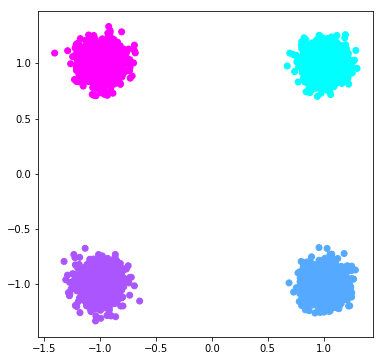

In [4]:
# visualize distribution of dataset
fig = plt.figure(figsize=1.5*plt.figaspect(1)) 
plt.scatter(X_train[:,0],X_train[:,1], c=y_train, cmap=plt.cm.cool)
plt.show()

In [32]:
# encoder neural network - take as input observation x, output mu and sigma of latent variable z and content h
class Encoder(object):
    def __init__(self,inputs,hidden_dim,z_dim,h_dim):
        self.X=inputs
        self.layer_dims=[self.X.get_shape().as_list()[1], hidden_dim, z_dim * 2 + h_dim] # output of Encoder (z_mu, z_sigma, h)
        self.nz=z_dim
        self.nh=h_dim
        with tf.variable_scope('encoder'):
            self.parameters = self._initialize_parameters()
            
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        
        w_s = tf.get_variable('w_s',[self.nz,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer(factor=0.2))
        w_o = tf.get_variable('w_o',[self.nz+self.nh,self.layer_dims[L-2]],initializer=tf.contrib.layers.variance_scaling_initializer())
        b_s = tf.get_variable('b_s',self.nz, initializer=tf.constant_initializer(-1))
        b_o = tf.get_variable('b_o',self.nz+self.nh, initializer=tf.constant_initializer(0))  
        parameters['W'+str(L-1)] = tf.concat([w_s,w_o],axis = 0,name='b'+str(L-1))
        parameters['b'+str(L-1)] = tf.concat([b_s,b_o],axis = 0,name='b'+str(L-1))
        return parameters
    
    def encoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
#                 A = tf.nn.dropout(A,keep_prob=0.5)
            else:  # activation for output layer
                A1 = 0.01*Z[:,:self.nz] #when initialize, set weights values very small using factor=0.002
                A2 = Z[:,self.nz:2 * self.nz] #mu
                A3 = Z[:,2 * self.nz:] #h
               
        return A1, A2, A3

In [33]:
# decoder neural network - take as input latent variable z, output reconstructed x_hat
class Decoder(object):
    def __init__(self,inputs,hidden_dim):
        self.X=inputs
        self.nz = self.X.get_shape().as_list()[1]
        self.layer_dims = [self.nz, hidden_dim, self.nz]
        with tf.variable_scope('decoder'):
            self.parameters = self._initialize_parameters()
            self.log_s = tf.get_variable('sigma',[1,self.nz],dtype=tf.float32)
    def _initialize_parameters(self):
        L=len(self.layer_dims)
        parameters={}
        for l in range(1,L):            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.variance_scaling_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.zeros_initializer())
        return parameters
    
    def decoding(self):
        L=len(self.layer_dims)    
        A=self.X
        for l in range(1,L):
            Z = tf.add(tf.matmul(A,tf.transpose(self.parameters['W'+str(l)])),self.parameters['b'+str(l)])
            if l < (L-1):  # activation for hidden layer
                A = tf.nn.relu(Z)
            else:  # activation for output layer
                A = Z               
        return A , self.log_s

In [34]:
# autoregressive neural network - take as input z_(t-1) and h, output mean and sigma of z_(t)
class AutoregNN(object):
    def __init__(self,input_z,input_h,layer_dims,idx,verbose = False):
        self.Z = input_z
        self.h = input_h
        self.z_dim = input_z.get_shape().as_list()[1]
        self.h_dim = input_h.get_shape().as_list()[1]
        self.D= self.z_dim
        self.layer_dims=layer_dims # z_dim + h_dim, arbitrary, arbitrary, z_dim + z_dim
        assert self.layer_dims[0] == self.z_dim + self.h_dim
        assert self.layer_dims[-1] == self.z_dim * 2
        self.verbose = verbose
        
        with tf.variable_scope('autoregressive_nn'+str(idx)):
            self.parameters=self._initialize_parameters()
        with tf.name_scope('autoregressive_nn'+str(idx)):
            self.mask=self.build_mask() 
        
    #initialize parameters
    def _initialize_parameters(self):
        L = len(self.layer_dims)
        parameters={}
        for l in range(1,L-1):
            
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.constant_initializer(0.)) 
        for l in [L-1]:
            parameters['W' + str(l)] = tf.get_variable('W'+str(l),[self.layer_dims[l],self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b'+str(l),self.layer_dims[l],initializer=tf.constant_initializer(2)) 

    
    
        #for direct connection
        parameters['WA']=tf.get_variable('WA',[self.layer_dims[L-1],self.z_dim],initializer=tf.contrib.layers.xavier_initializer())
        parameters['bA']=tf.get_variable('bA',self.layer_dims[L-1],initializer=tf.zeros_initializer())
        
        return parameters 

    # build mask    
    def single_mask(self, m_h, l, Isoutput=False):
        if l==0:
            raise ValueError('No mask for W0')        
        if Isoutput==False:
            M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if Isoutput==True:
            M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(self.layer_dims[l-1])] for k in range(self.layer_dims[l])],dtype=int)
        if self.verbose:
            print('M%d:'%l + '{}'.format(M))
        return M    
    
    def build_mask(self):
        L=len(self.layer_dims)
        mask={}        
        #create mask number of each unit
        input_sel_z = np.arange(0,self.z_dim)
        input_sel_h = np.zeros(self.h_dim)-1 # a little trick to let input h be fully connected to first hidden layer 
                                    # it shouldn't have mask, but we set the mask to be True = set input_sel_h smaller than any mask number
        input_sel = np.concatenate((input_sel_z,input_sel_h))
        output_sel = np.concatenate((input_sel_z, input_sel_z))
        m_h=[input_sel]
        for l in range(1,L-1):
            m_h.append(np.random.randint(self.D-1,size=self.layer_dims[l]))
        m_h.append(output_sel)
        if self.verbose:
            print('m_h: {}'.format(m_h))
        
        for l in range(1,L-1):
            M=self.single_mask(m_h,l,Isoutput=False)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
        for l in range(L-1,L):           
            M=self.single_mask(m_h,l,Isoutput=True)
            mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    
        # for direct connection
        input_sel_direct = input_sel_z
        output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
        M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
        if self.verbose:
            print('MA: {}'.format(M))
        mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')                      
        
        return mask
    
    # forward compute
    def iaf(self):
        L=len(self.layer_dims)    
        A_in=tf.concat((self.Z,self.h),axis = 1)
        A = A_in
        for l in range(1,L):
            masked_W=np.dot(self.parameters['W'+str(l)], self.mask['M'+str(l)])
            b=self.parameters['b'+str(l)]
            Z=tf.add(tf.matmul(A,tf.transpose(masked_W)),b)
            if l < (L-1):  # activation for hidden layer
                A=tf.nn.relu(Z)
            else:  # activation for output layer
                A=Z 
                
        #for direct conection
        masked_W= np.dot(self.parameters['WA'], self.mask['MA'])
        A_direct=tf.matmul(self.Z,tf.transpose(masked_W))
        
        A = tf.add(A,A_direct)
        A1 = A[:,self.z_dim:] #s
        A2 = A[:,:self.z_dim] #m

        
        return A1,A2

In [35]:
# built model
tf.reset_default_graph()
with tf.name_scope('inputs'):
    X=tf.placeholder(shape=[None,2],dtype=tf.float32)
with tf.name_scope('encoding_stage'):
    encoder=Encoder(inputs=X,hidden_dim=10,z_dim=2,h_dim=4)
    z_log_sigma_0,z_mu_0,h=encoder.encoding()
    epsilon = tf.random_normal(tf.shape(z_mu_0),0,1,dtype=tf.float32)
    Z = np.dot(tf.exp(z_log_sigma_0/2) , epsilon) + z_mu_0

with tf.name_scope('iaf_stage'):
    z_sigmas=[]
    for t in range(4):
        reverse = t>0
        if reverse:
            Z = Z[:,::-1]
        IAF = AutoregNN(input_z=Z,input_h=h,layer_dims=[6,10,10,4],idx=t)
        m,s = IAF.iaf()
        z_sigma = tf.sigmoid(s)
        Z = np.dot(z_sigma , Z) + np.dot(1 - z_sigma ,  m)
        z_sigmas.append(z_sigma)

with tf.name_scope('decoding_stage'):
    decoder=Decoder(inputs=Z,hidden_dim=10)
    x_mu_hat,x_sigma_hat = decoder.decoding()

#x_hat is only for visulization, not concerning training
with tf.name_scope('visulization_x_hat'):
    X_hat = np.dot(epsilon, x_sigma_hat) + x_mu_hat

In [36]:
# mini batch gradient descent
def get_mini_batch(X,y,batch_size=200):
           
    n = X.shape[0]   
    mini_batches = []
    permutation = np.random.permutation(n)
    shuffled_X = X[permutation,:] 
    shuffled_y = y[permutation]
    
    num_complete_minibatches = math.floor(n/batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * batch_size:(k + 1) * batch_size,:] 
        mini_batch_y = shuffled_y[k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X,mini_batch_y))
    if n % batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * batch_size:,:]
        mini_batch_y = shuffled_y[num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X,mini_batch_y))
    
    return mini_batches 

In [37]:
# vae - iaf negative evidence lower bound - based on monte carlo sampling
def neg_elbo(X,x_mu_hat,Z):
    # log p(z_t)
    log_pz = -tf.reduce_sum(0.5*tf.log(2*math.pi) + 0.5*Z**2, axis=-1)
    # log p(x|z_t)
    log_px = 0.5*tf.reduce_sum(tf.log(2*math.pi)+tf.square(X-x_mu_hat)/tf.exp(x_sigma_hat) + x_sigma_hat,axis=-1)     
    # log q(z_t|x)
    det=np.zeros_like(z_sigmas[0])
    for item in z_sigmas:
        det+=tf.log(item)    
    log_qz = -tf.reduce_sum(0.5*tf.log(2*math.pi) + 0.5*epsilon**2 + 0.5*z_log_sigma_0 + det,axis=-1)     

    return tf.reduce_mean(log_px+log_qz-log_pz) 

In [38]:
def random_data(num_dataset):
    assert num_dataset % 4 == 0
    num_each_class = int(num_dataset/4)
    means0=np.array([[1,1],[1,-1],[-1,-1],[-1,1]])
    sigma0=0.1
    X=np.random.randn(num_dataset,2)
    y=np.zeros(num_dataset).astype(int)
    for i in range(4):
        X[i*num_each_class:(i+1)*num_each_class,:]=sigma0 * X[i*num_each_class:(i+1)*num_each_class,:] + means0[i]
        y[i*num_each_class:(i+1)*num_each_class] += i
    return X,y

In [48]:
file_path="maybe/iaf.ckpt"

In [52]:
# training
def training(X_train, y_train, X_val, y_val, num_epochs = 1000, batch_size = 32, log_every=10,learning_rate = 0.001, verbose = False):

    with tf.name_scope('training_loss'):
        loss = neg_elbo(X,x_mu_hat,Z)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # training
    iterations_per_epoch = max(num_training // batch_size,1)
    counter=0

    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):            
            idx=np.random.choice(num_training,batch_size)
            mini_batch = X_train[idx,:]
            mini_label=y_train[idx]+1
            counter +=1
            _,temp_cost,z_values=sess.run([optimizer,loss,z_log_sigma_0],feed_dict={X:mini_batch})
            
        
            
            if verbose and epoch % log_every ==0:
                print('%d-th train ' % (epoch) + 'cost:{} '.format(temp_cost))
            if epoch%50000==0:
                saver.save(sess,file_path)

        # vizualize results x_hat and z
        mu_val,x_val,z_val=sess.run([x_mu_hat,X_hat,Z],{X:X_train})
        fig = plt.figure(figsize=2*plt.figaspect(1))
        plt.scatter(mu_val[:,0],mu_val[:,1],c=y_train,cmap=plt.cm.cool)
        fig = plt.figure(figsize=2*plt.figaspect(1))
        plt.scatter(z_val[:,0],z_val[:,1],c=y_train,cmap=plt.cm.cool)
        plt.show()
    return None

0-th train cost:9.4765043258667 
1000-th train cost:2.7964823246002197 
2000-th train cost:2.783355712890625 
3000-th train cost:2.786243438720703 
4000-th train cost:2.4407284259796143 
5000-th train cost:1.4809601306915283 
6000-th train cost:1.5763593912124634 
7000-th train cost:1.4265906810760498 
8000-th train cost:1.2264513969421387 
9000-th train cost:1.6347070932388306 
10000-th train cost:0.8813876509666443 
11000-th train cost:0.7202855348587036 
12000-th train cost:0.29701530933380127 
13000-th train cost:0.4701462984085083 
14000-th train cost:0.6856728792190552 
15000-th train cost:-0.2402501404285431 
16000-th train cost:0.7571902871131897 
17000-th train cost:-0.09121593832969666 
18000-th train cost:0.3762834072113037 
19000-th train cost:0.34521588683128357 
20000-th train cost:0.38699495792388916 
21000-th train cost:0.16414491832256317 
22000-th train cost:-0.018313229084014893 
23000-th train cost:0.3325808644294739 
24000-th train cost:0.6084524989128113 
25000-th

198000-th train cost:0.10401405394077301 
199000-th train cost:-0.024088993668556213 
200000-th train cost:-0.44541871547698975 
201000-th train cost:-0.10025140643119812 
202000-th train cost:-0.48188096284866333 
203000-th train cost:0.15967778861522675 
204000-th train cost:-0.12635791301727295 
205000-th train cost:-0.0357581228017807 
206000-th train cost:-0.08263607323169708 
207000-th train cost:-0.009636849164962769 
208000-th train cost:0.14259018003940582 
209000-th train cost:0.12060891091823578 
210000-th train cost:0.25303512811660767 
211000-th train cost:-0.041346073150634766 
212000-th train cost:-0.13741666078567505 
213000-th train cost:-0.13030263781547546 
214000-th train cost:-0.0734705775976181 
215000-th train cost:0.17244890332221985 
216000-th train cost:0.2779081463813782 
217000-th train cost:-0.4366002678871155 
218000-th train cost:-0.1253458708524704 
219000-th train cost:-0.26071852445602417 
220000-th train cost:-0.2386106550693512 
221000-th train cost:

392000-th train cost:-0.3846588730812073 
393000-th train cost:-0.06858280301094055 
394000-th train cost:-0.5434128046035767 
395000-th train cost:-0.26224485039711 
396000-th train cost:0.5430249571800232 
397000-th train cost:0.06811530143022537 
398000-th train cost:-0.4146578311920166 
399000-th train cost:-0.08942072093486786 
400000-th train cost:0.15946783125400543 
401000-th train cost:-0.2531939744949341 
402000-th train cost:-0.5132889747619629 
403000-th train cost:-0.2905588150024414 
404000-th train cost:-0.18279337882995605 
405000-th train cost:-0.1918397843837738 
406000-th train cost:-0.21501269936561584 
407000-th train cost:0.29764506220817566 
408000-th train cost:-0.23733064532279968 
409000-th train cost:0.23681338131427765 
410000-th train cost:0.1355244517326355 
411000-th train cost:-0.2883848249912262 
412000-th train cost:-0.3315090239048004 
413000-th train cost:-0.04649455100297928 
414000-th train cost:0.02343951165676117 
415000-th train cost:-0.04754798

586000-th train cost:-0.2820889949798584 
587000-th train cost:-0.15267091989517212 
588000-th train cost:-0.07460486888885498 
589000-th train cost:-0.37224000692367554 
590000-th train cost:-0.34510523080825806 
591000-th train cost:-0.5065470933914185 
592000-th train cost:-0.34713679552078247 
593000-th train cost:-0.3653695285320282 
594000-th train cost:-0.06280654668807983 
595000-th train cost:-0.16794751584529877 
596000-th train cost:-0.3517000675201416 
597000-th train cost:-0.39248451590538025 
598000-th train cost:0.0812157392501831 
599000-th train cost:-0.3009675145149231 
600000-th train cost:-0.2399245798587799 
601000-th train cost:0.5199434757232666 
602000-th train cost:-0.26841676235198975 
603000-th train cost:-0.0233101025223732 
604000-th train cost:-0.05327498912811279 
605000-th train cost:0.07280384004116058 
606000-th train cost:-0.1831541508436203 
607000-th train cost:-0.3911634087562561 
608000-th train cost:0.051130399107933044 
609000-th train cost:0.00

780000-th train cost:-0.32078441977500916 
781000-th train cost:0.019288212060928345 
782000-th train cost:-0.39574652910232544 
783000-th train cost:-0.27035385370254517 
784000-th train cost:0.15243667364120483 
785000-th train cost:-0.0026285648345947266 
786000-th train cost:0.4754799008369446 
787000-th train cost:-0.14965976774692535 
788000-th train cost:-0.7265194058418274 
789000-th train cost:-0.1578843742609024 
790000-th train cost:-0.10041112452745438 
791000-th train cost:0.1436583548784256 
792000-th train cost:-0.41599392890930176 
793000-th train cost:-0.0766855999827385 
794000-th train cost:0.04352917522192001 
795000-th train cost:0.024530023336410522 
796000-th train cost:0.37768223881721497 
797000-th train cost:-0.28229689598083496 
798000-th train cost:0.039754994213581085 
799000-th train cost:-0.20961713790893555 
800000-th train cost:0.024754837155342102 
801000-th train cost:0.020764052867889404 
802000-th train cost:0.20917436480522156 
803000-th train cost

974000-th train cost:-0.35377877950668335 
975000-th train cost:-0.30489110946655273 
976000-th train cost:0.222215473651886 
977000-th train cost:-0.42246776819229126 
978000-th train cost:-0.08053625375032425 
979000-th train cost:0.018981508910655975 
980000-th train cost:-0.2689133584499359 
981000-th train cost:-0.06998048722743988 
982000-th train cost:-0.37517720460891724 
983000-th train cost:0.19766205549240112 
984000-th train cost:-0.1400468647480011 
985000-th train cost:-0.5156723260879517 
986000-th train cost:0.15926724672317505 
987000-th train cost:-0.4500029683113098 
988000-th train cost:0.00928594172000885 
989000-th train cost:0.24653583765029907 
990000-th train cost:-0.3869287073612213 
991000-th train cost:-0.20800481736660004 
992000-th train cost:0.6792623996734619 
993000-th train cost:-0.319806307554245 
994000-th train cost:-0.15950283408164978 
995000-th train cost:-0.14099252223968506 
996000-th train cost:0.4680631756782532 
997000-th train cost:-0.12898

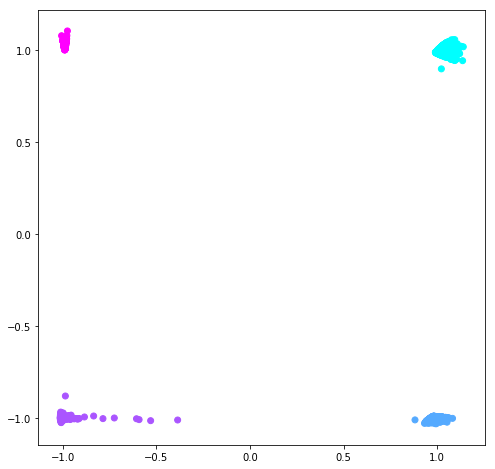

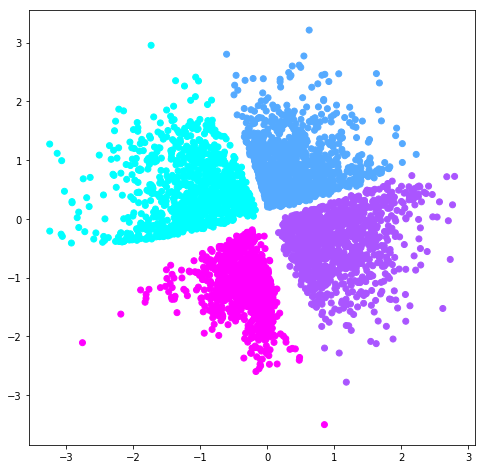

In [61]:
training(X_train,y_train,X_val,y_val,num_epochs=1000000, batch_size = 16, log_every = 1000, verbose=True)

INFO:tensorflow:Restoring parameters from maybe/iaf.ckpt


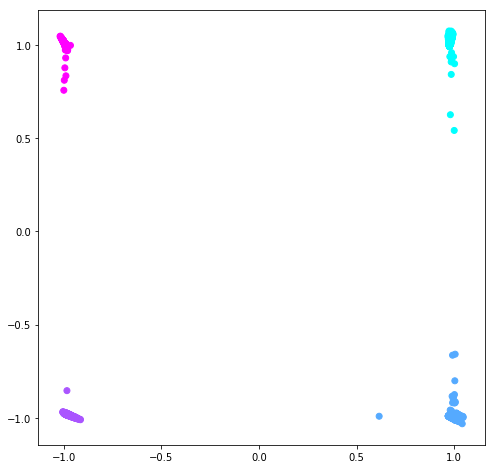

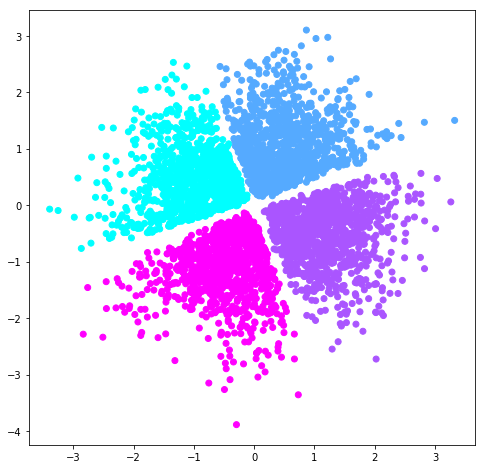

[[-4.52392  -4.547797]]


In [64]:
with tf.Session() as sess:
    saver=tf.train.Saver()
    saver.restore(sess,file_path)
    mu_val,x_val,z_val=sess.run([x_mu_hat,X_hat,Z],feed_dict={X:X_train})
    fig = plt.figure(figsize=2*plt.figaspect(1))
    plt.scatter(mu_val[:,0],mu_val[:,1],c=y_train,cmap=plt.cm.cool)
    fig = plt.figure(figsize=2*plt.figaspect(1))
    plt.scatter(z_val[:,0],z_val[:,1],c=y_train,cmap=plt.cm.cool)
    plt.show()
    print(x_sigma_hat.eval())